<a href="https://colab.research.google.com/github/s2t2/ml-music/blob/main/notebooks/gtzan/csv/Genre_Classification_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FINAL PROJECT Module 3: Fit Naive Bayes, MaxEnt, and Support Vector classifiers to your dataset identified in Module #1. 

Using your knowledge of this dataset, choose a metric to score the quality of your classifiers and justify your choice of metric in the context of a specific problem that your data would address. 

Indicate which classifier achieves the highest scores and speculate why this might be the case given your knowledge of the dataset.

Finally, provide contingency tables and plots of the ROC curve for each classifier and indicate the strengths and weaknesses of each classifier for your specific dataset.

## Setup

1. Download dataset from kaggle: 
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification.

2. Upload to your Google Drive. Store folder as "gtzan" and reference the path. 
3. Create a shortcut to this directory in your google drive at the `DATASET_PATH`, OR update the `DATASET_PATH` below as necessary to match where you uploaded the "gtzan" folder.



In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# you might need to update the path below, or create a shortcut to the path below
DATASET_PATH = '/content/drive/MyDrive/Research/DS Research Shared 2023/data/gtzan'

print(DATASET_PATH)
assert os.path.isdir(DATASET_PATH)

/content/drive/MyDrive/Research/DS Research Shared 2023/data/gtzan


In [3]:
GENRES_DIRPATH = os.path.join(DATASET_PATH, "genres_original")
print(os.listdir(GENRES_DIRPATH))

['hiphop', 'country', 'rock', 'disco', 'metal', 'reggae', 'blues', 'classical', 'pop', 'jazz']


In [4]:
from IPython.display import Audio, display

genre = "pop" # @param ['hiphop', 'country', 'rock', 'disco', 'metal', 'reggae', 'blues', 'classical', 'pop', 'jazz']

audio_path = os.path.join(GENRES_DIRPATH, genre, f"{genre}.00038.wav")
display(Audio(filename=audio_path))

## Load Data

We have a file of 3 second features, and a file of 30 second features. We saw last time that the 30 second features led to better performance, so we'll stick with those here.

In [5]:
#from pandas import read_csv
#
#CSV_FILEPATH = os.path.join(DATASET_PATH, "features_3_sec.csv")
#
#df3 = read_csv(CSV_FILEPATH)
#print(df3.shape) #> 9990 rows, 60 cols
#print(df3.columns.tolist())
#df3.to_csv("features_3_sec.csv")
#df3.head()

In [6]:
from pandas import read_csv

CSV_FILEPATH = os.path.join(DATASET_PATH, "features_30_sec.csv")

df30 = read_csv(CSV_FILEPATH)
print(df30.shape) #> 1000 rows, 60 cols
print(df30.columns.tolist())
df30.to_csv("features_30_sec.csv")
df30.head()

(1000, 60)
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


### Feature Analysis

Let's analyze the features and their distributions.

In [7]:
target = 'label'
features = [
    'chroma_stft_mean', 'chroma_stft_var', 
    'rms_mean', 'rms_var', 
    'spectral_centroid_mean', 'spectral_centroid_var', 
    'spectral_bandwidth_mean', 'spectral_bandwidth_var', 
    'rolloff_mean', 'rolloff_var', 
    'zero_crossing_rate_mean', 'zero_crossing_rate_var', 
    'harmony_mean', 'harmony_var', 
    'perceptr_mean', 'perceptr_var', 
    'tempo', 
    'mfcc1_mean', 'mfcc1_var', 
    'mfcc2_mean', 'mfcc2_var', 
    'mfcc3_mean', 'mfcc3_var', 
    'mfcc4_mean', 'mfcc4_var', 
    'mfcc5_mean', 'mfcc5_var', 
    'mfcc6_mean', 'mfcc6_var', 
    'mfcc7_mean', 'mfcc7_var', 
    'mfcc8_mean', 'mfcc8_var', 
    'mfcc9_mean', 'mfcc9_var', 
    'mfcc10_mean', 'mfcc10_var', 
    'mfcc11_mean', 'mfcc11_var', 
    'mfcc12_mean', 'mfcc12_var', 
    'mfcc13_mean', 'mfcc13_var', 
    'mfcc14_mean', 'mfcc14_var', 
    'mfcc15_mean', 'mfcc15_var', 
    'mfcc16_mean', 'mfcc16_var', 
    'mfcc17_mean', 'mfcc17_var', 
    'mfcc18_mean', 'mfcc18_var', 
    'mfcc19_mean', 'mfcc19_var', 
    'mfcc20_mean', 'mfcc20_var', 
]

In [8]:
df30[features].describe()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,2.555262e+06,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,8.660900e+06,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


In [9]:
import plotly.express as px

#colnames = ["length", "mfcc1_mean", "mfcc1_var"]
for colname in features:

    fig = px.histogram(df30[colname], height=400, title=f"Distribution of Tracks by {colname}")
    fig.show()


## Plotting Functions

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(clf, y_test, y_pred, model_name=None):
    """Params 
        clf : an sklearn classifier 
        model_name : title for chart, like "Logistic Regression"
    """

    model_name = model_name or clf.__class__.__name__

    classes = clf.classes_

    cm = confusion_matrix(y_test, y_pred)
    # Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
    # ... true label being i-th class and predicted label being j-th class.

    # df = DataFrame(cm, columns=classes, index=classes)

    sns.set(rc = {'figure.figsize':(6,6)})

    sns.heatmap(cm, 
                square=True, annot=True, cbar=True,
                xticklabels=classes,
                yticklabels=classes,            
                cmap= "Blues" #"Blues" #"viridis_r" #"rocket_r" # r for reverse
    )

    plt.ylabel("True Genre") # cm rows are true
    plt.xlabel("Predicted Genre") # cm cols are preds
    plt.title(f"Confusion Matrix on Test Data ({model_name})")
    plt.show()



In [11]:
#
# AUC PLOTTING FUNCTION (DOESN'T WORK FOR MULTICLASS)
#

#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn import metrics
#
#def plot_auc(fpr: np.array, tpr: np.array, title="Receiver operating characteristic"):
#    """Plots the ROC characteristic and the AUC Score
#
#        See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
#        
#        Params: 
#
#            fpr: False positive rate 
#            tpr: True positive rate 
#        
#        ... like:
#
#            fpr, tpr, thresholds = metrics.roc_curve(y_true.to_numpy(), y_pred.to_numpy()) # , pos_label=2  
#    """
#
#    fig, ax = plt.subplots(figsize=(10,10))
#    roc_auc = metrics.auc(fpr, tpr)
#    lw = 2
#    ax.plot(
#        fpr,
#        tpr,
#        color="darkorange",
#        lw=lw,
#        label="ROC curve (area = %0.2f)" % roc_auc,
#    )
#    ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
#    ax.set_xlim([0.0, 1.0])
#    ax.set_ylim([0.0, 1.0])
#    plt.xlabel("False Positive Rate")
#    plt.ylabel("True Positive Rate")
#    plt.title(title)
#    plt.legend(loc="lower right")
#    plt.show()


In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, RocCurveDisplay #, roc_auc_score
import matplotlib.pyplot as plt

def plot_auc_multiclass(clf, x_test, y_train, y_test, model_name=None):
    model_name = model_name or clf.__class__.__name__

    y_pred_proba = clf.predict_proba(x_test)

    #
    # APPROACH A (OVERALL SCORE ONLY)
    #
    #roc_auc_result = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="micro")
    #print("Micro-averaged One-vs-Rest ROC AUC score:")
    #print(f"{roc_auc_result:.2f}")

    #
    # APPROACH B (WITH PLOTTING CAPABILITIES)
    #
    
    lb = LabelBinarizer().fit(y_train)
    y_test_onehot = lb.transform(y_test)
    y_test_onehot.shape  # (n_samples, n_classe

    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("Micro-averaged One-vs-Rest ROC AUC score:")
    print(f"{roc_auc['micro']:.2f}")

    RocCurveDisplay.from_predictions(y_test_onehot.ravel(), y_pred_proba.ravel(), name="micro-average OvR", color="darkorange")
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Micro-averaged One-vs-Rest\nReceiver Operating Characteristic\n({model_name})")
    plt.legend()
    plt.show()

## Classifiers

### Logistic Regression



In [13]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from pandas import Series


def logistic_pipeline_cv(df=df30, features=features, target=target, scale=True):

    x = df[features]
    y = df[target]
    #print(x.shape, y.shape)

    if scale:
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        x = DataFrame(x, columns=features)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    model = LogisticRegression(random_state=99, max_iter=5_000)
    gs = GridSearchCV(model, cv=10, param_grid={
        #"penalty": ["l1", "l2", "elasticnet", None] 
    })

    gs.fit(x_train, y_train)
    best_est = gs.best_estimator_
    print("BEST SCORE:", gs.best_score_)
    print("BEST PARAMS:", gs.best_params_)
    print("CLASSES:", gs.classes_)
    print("COEFS:")
    coefs = Series(best_est.coef_[0], index=features).sort_values(ascending=False)
    print(coefs.head())
    print(coefs.tail())

    y_pred = gs.predict(x_test)
    #y_probs = gs.predict_proba(x_test)

    print(classification_report(y_test, y_pred))

    plot_confusion_matrix(gs, y_test, y_pred, model_name=best_est.__class__.__name__)

    plot_auc_multiclass(best_est, x_test, y_train, y_test)


BEST SCORE: 0.67125
BEST PARAMS: {}
CLASSES: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
COEFS:
mfcc6_mean         1.974925
mfcc3_mean         1.943465
chroma_stft_var    1.585289
mfcc4_mean         1.393443
rms_mean           1.173440
dtype: float64
rolloff_mean              -1.296423
spectral_bandwidth_mean   -1.299066
spectral_centroid_mean    -1.300938
mfcc12_mean               -1.301466
mfcc17_mean               -1.420555
dtype: float64
              precision    recall  f1-score   support

       blues       0.55      0.50      0.52        22
   classical       0.86      0.90      0.88        21
     country       0.64      0.47      0.55        19
       disco       0.50      0.53      0.52        15
      hiphop       0.77      0.43      0.56        23
        jazz       0.78      0.84      0.81        25
       metal       0.69      0.86      0.77        21
         pop       0.77      0.81      0.79        21
      reggae       0.58 

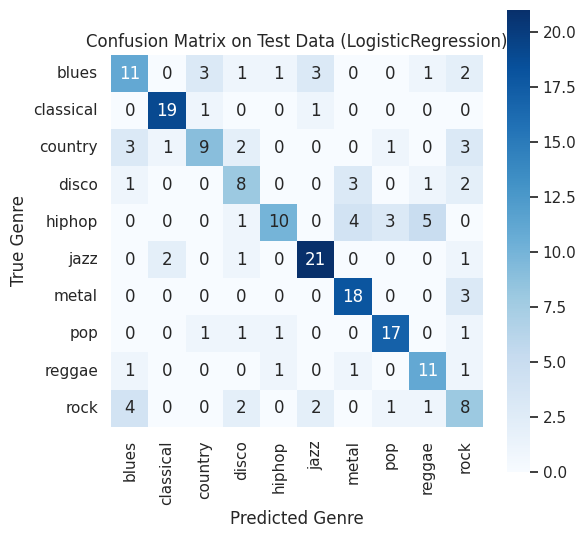

Micro-averaged One-vs-Rest ROC AUC score:
0.95


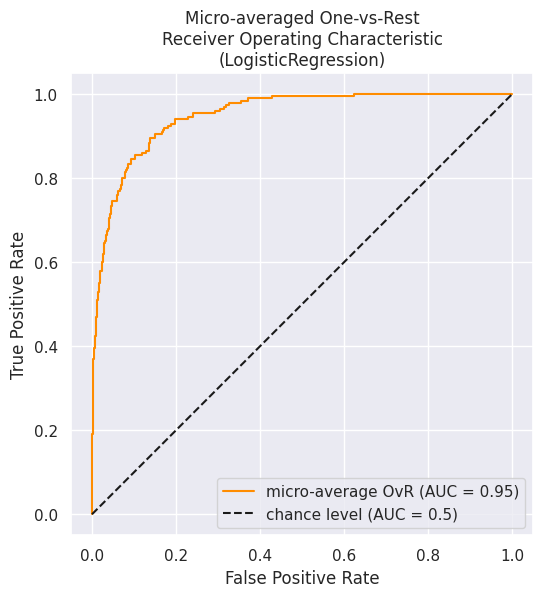

In [14]:
logistic_pipeline_cv()

In [15]:
#logistic_pipeline_cv(features=["mfcc6_mean", "mfcc3_mean", "chroma_stft_var"])

### Naive Bayes

0.55
{}
              precision    recall  f1-score   support

       blues       0.83      0.23      0.36        22
   classical       0.79      0.90      0.84        21
     country       0.52      0.58      0.55        19
       disco       0.25      0.33      0.29        15
      hiphop       0.58      0.30      0.40        23
        jazz       0.73      0.44      0.55        25
       metal       0.45      0.86      0.59        21
         pop       0.71      0.71      0.71        21
      reggae       0.36      0.33      0.34        15
        rock       0.22      0.33      0.27        18

    accuracy                           0.51       200
   macro avg       0.55      0.50      0.49       200
weighted avg       0.57      0.51      0.50       200



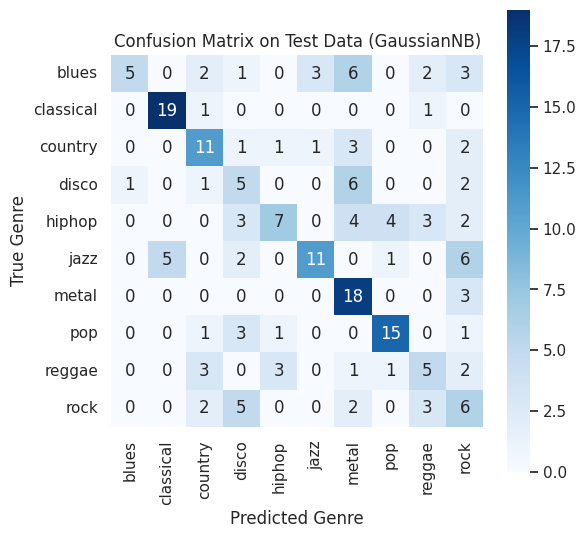

Micro-averaged One-vs-Rest ROC AUC score:
0.90


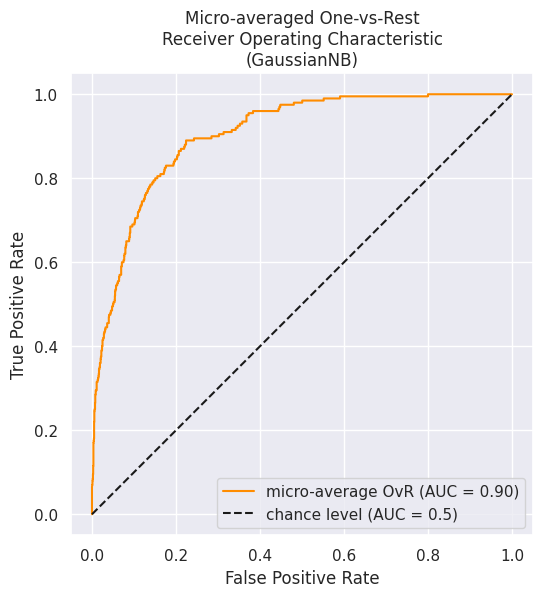

In [16]:
from scipy.sparse import random
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split


# https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
# which to choose?
# GaussianNB implements the Gaussian Naive Bayes algorithm for classification
# BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarize its input (depending on the binarize parameter).
# MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). 
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from pandas import Series


def naive_bayes_pipeline_cv(df=df30, features=features, target=target, scale=True, param_grid={}):

    x = df[features]
    y = df[target]
    #print(x.shape, y.shape)
    if scale:
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        x = DataFrame(x, columns=features)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    model = GaussianNB() #> 0.51
    #model = MultinomialNB() #> 0.41 
    gs = GridSearchCV(model, cv=10, param_grid=param_grid)

    gs.fit(x_train, y_train)
    print(gs.best_score_)
    print(gs.best_params_)
    best_est = gs.best_estimator_

    y_pred = gs.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(gs, y_test, y_pred, model_name=best_est.__class__.__name__)

    plot_auc_multiclass(best_est, x_test, y_train, y_test)



naive_bayes_pipeline_cv()

In [17]:
#naive_bayes_pipeline_cv(features=normal_features)

### Support Vector Classifier

0.73
{'kernel': 'poly'}
              precision    recall  f1-score   support

       blues       0.71      0.91      0.80        22
   classical       1.00      0.90      0.95        21
     country       0.62      0.53      0.57        19
       disco       0.50      0.80      0.62        15
      hiphop       0.85      0.48      0.61        23
        jazz       0.89      1.00      0.94        25
       metal       0.76      0.76      0.76        21
         pop       0.89      0.81      0.85        21
      reggae       0.62      0.67      0.65        15
        rock       0.56      0.50      0.53        18

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.76      0.74      0.74       200



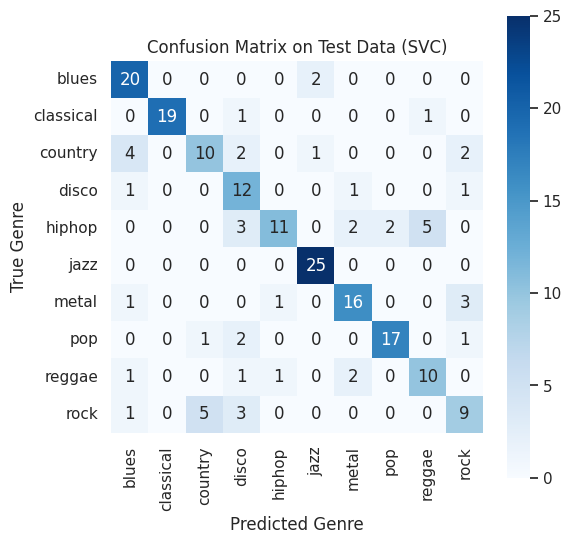

Micro-averaged One-vs-Rest ROC AUC score:
0.97


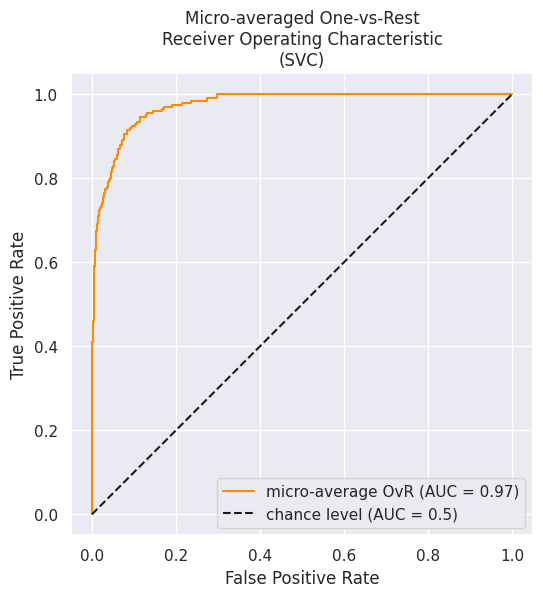

In [18]:
from scipy.sparse import random
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from pandas import Series


def svc_pipeline_cv(df=df30, features=features, target=target, scale=True, param_grid={}):

    x = df[features]
    y = df[target]
    #print(x.shape, y.shape)

    if scale:
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x)
        x = DataFrame(x, columns=features)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    #model = SVC(kernel=kernel, gamma=gamma, random_state=99) # gamma=gamma
    model = SVC(random_state=99, probability=True) # probability=True enables .predict_proba()
    gs = GridSearchCV(model, cv=10, param_grid=param_grid)

    gs.fit(x_train, y_train)
    print(gs.best_score_)
    print(gs.best_params_)
    best_est = gs.best_estimator_
    #if kernel == "linear":
    #    print(best_est.coef_)
    #    print(best_est.intercept_)
    #    features = x.columns.tolist()
    #    print(Series(best_est.coef_[0], index=features).sort_values(ascending=False))

    y_pred = gs.predict(x_test)
    print(classification_report(y_test, y_pred))
    
    plot_confusion_matrix(gs, y_test, y_pred, model_name=best_est.__class__.__name__)

    plot_auc_multiclass(best_est, x_test, y_train, y_test)


svc_pipeline_cv(param_grid={"kernel": ["linear", "poly", "rbf", "sigmoid"]})

0.73
{'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
              precision    recall  f1-score   support

       blues       0.71      0.91      0.80        22
   classical       1.00      0.90      0.95        21
     country       0.62      0.53      0.57        19
       disco       0.50      0.80      0.62        15
      hiphop       0.85      0.48      0.61        23
        jazz       0.89      1.00      0.94        25
       metal       0.76      0.76      0.76        21
         pop       0.89      0.81      0.85        21
      reggae       0.62      0.67      0.65        15
        rock       0.56      0.50      0.53        18

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.73       200
weighted avg       0.76      0.74      0.74       200



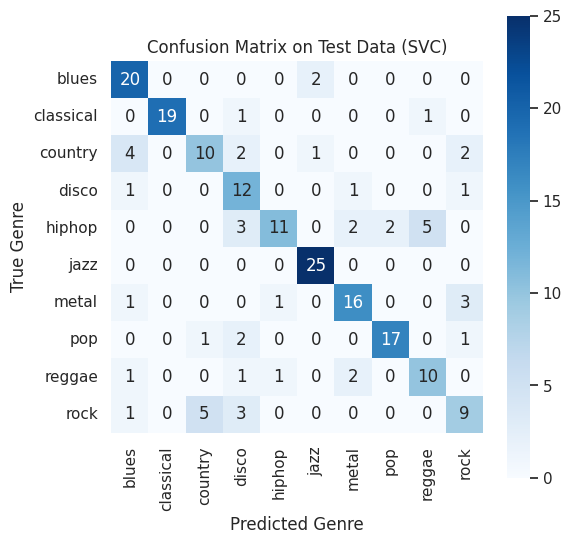

Micro-averaged One-vs-Rest ROC AUC score:
0.97


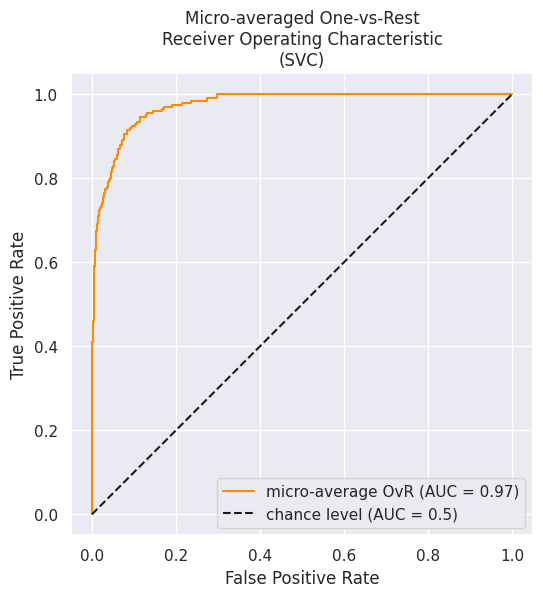

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
# degree int, default=3
# Degree of the polynomial kernel function (‘poly’). Must be non-negative. Ignored by all other kernels.
#
# gamma{‘scale’, ‘auto’} or float, default=’scale’
# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

svc_pipeline_cv(param_grid={
    "kernel": ["poly"],
    "degree": [ 
        #1,
        2,3,4, 
        #5,10,
        #20
        ],
    "gamma": ["scale", "auto"]

})


## Results Summary and Interpretation

The metric of choice is general classification accuracy. We don't really yet have a need to prefer a different score. Although we could also take a look at ROC / AUC score (in this case micro-averaged because of the multi-class problem).


A) The Logistic Regression acheives 66% accuracy (and AUC of 90%) on the test data.

B) The Gaussian Naive Bayes acheives 51% accuracy (and AUC of 95%).

> NOTE: the Multinomial Naive Bayes acheives 41% accuracy, which is lower than the Gaussian version. This could be because some of our features have a Gaussian distribution, which might make the Gaussian version an appropriate choice.

C) The best SVC, which uses a polynomial kernel (with degree of three), acheives 74% accy (and AUC of 97%).






Since we have ten classes, a guess would be 10% accuracy, so the results of all these models are pretty good so far. The SVC has the best accuracy and AUC scores, so we can consider it to be the best performing. This may be because the SVC uses a polynomial kernel function to handle non-linear decision boundaries, whereas the Logistic Regression and Naive Bayes can be considered as linear models (see references below).

References:

  + https://stats.stackexchange.com/questions/88603/why-is-logistic-regression-a-linear-model
  + https://stats.stackexchange.com/questions/142215/how-is-naive-bayes-a-linear-classifier
  + https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html 

## Scratch Work

The section below contains some commented out code used during the development of this notebook

In [20]:
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
## Test whether a sample differs from a normal distribution.
## This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis to produce an omnibus test of normality.
#
#from scipy.stats import normaltest
#from pandas import DataFrame
#
#alpha = 1e-3
#
#normality_results = []
#
#for colname in features:
#
#    x_col = df30[colname].tolist()
#    
#    k2_score, p_val = normaltest(x_col)
#    #print("K2 SCORE:", k2_score)
#    #print(f"P_VAL: {p_val:g}")
#    #if p_val < alpha:  # null hypothesis: x comes from a normal distribution
#    #    print("The null hypothesis can be rejected")
#    #else:
#    #    print("The null hypothesis cannot be rejected")
#
#    normality_results.append({"colname": colname, "score": k2_score, "p_val": p_val})
#
#norm_df = DataFrame(normality_results)
#normal_features = norm_df[norm_df["p_val"] > alpha]["colname"].tolist()
#norm_df[norm_df["p_val"] >= alpha] # the ones that come from a normal dist

In [21]:
#from sklearn.preprocessing import MinMaxScaler
#from pandas import DataFrame
#
#scaler = MinMaxScaler()
#scaled30 = scaler.fit_transform(df30[features])
#
#scaled30 = DataFrame(scaled30, columns=features)
#scaled30.head()

In [22]:
#scaled30.mean()

In [23]:
#from sklearn.linear_model import LogisticRegression
#
#model = LogisticRegression(random_state=99, max_iter=10_000)
#
#model.__class__.__name__

In [24]:
#df=df30
#features=features
#target=target
#scale=True
#
#x = df[features]
#y = df[target]
##print(x.shape, y.shape)
#
#if scale:
#    scaler = MinMaxScaler()
#    x = scaler.fit_transform(x)
#    x = DataFrame(x, columns=features)


In [25]:
#x.head()

In [26]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=99)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape)


In [27]:

#model = LogisticRegression(random_state=99, max_iter=10_000)
#gs = GridSearchCV(model, cv=10, param_grid={
#    #"penalty": ["l1", "l2", "elasticnet", None] 
#})
#
#gs.fit(x_train, y_train)
#best_est = gs.best_estimator_
#print("BEST SCORE:", gs.best_score_)
#print("BEST PARAMS:", gs.best_params_)
#print("CLASSES:", gs.classes_)
#
#coefs = Series(best_est.coef_[0], index=features).sort_values(ascending=False)
#print(coefs.head(3))
#
#y_pred = gs.predict(x_test)
#print(classification_report(y_test, y_pred))

In [28]:
#coefs = Series(best_est.coef_[0], index=features).sort_values(ascending=False)
#print(coefs.head(3))
#print(coefs.tail(3))

In [29]:
#from sklearn.metrics import classification_report, confusion_matrix
#
#cm = confusion_matrix(y_test, y_pred
#                      #, labels=gs.classes_, 
#                          #sample_weight=None, normalize=None
#                          )
#cm
#DataFrame(cm, columns=gs.classes_, index=gs.classes_)

In [30]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#
#sns.set(rc = {'figure.figsize':(10,10)})
#
#sns.heatmap(cm, 
#            square=True, annot=True, cbar=True,
#            xticklabels=gs.classes_,
#            yticklabels=gs.classes_,            
#            # https://stackoverflow.com/questions/47461506/how-to-invert-color-of-seaborn-heatmap-colorbar
#            cmap= "Blues" #"Blues" #"viridis_r" #"rocket_r" # r for reverse
#)
#
## Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
## ... true label being i-th class and predicted label being j-th class.
#plt.xlabel("Predicted Genre")
#plt.ylabel("True Genre")
#plt.title("Confusion Matrix on Test Data (Logistic Regression)")
#plt.show()


In [31]:
## https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
#
#from sklearn.metrics import roc_auc_score
#
#y_pred_proba = gs.predict_proba(x_test)
#
#roc_auc_result = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="micro")
#print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc_result:.2f}")

In [32]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc
#
#from sklearn.preprocessing import LabelBinarizer
#
#label_binarizer = LabelBinarizer().fit(y_train)
#y_test_onehot = label_binarizer.transform(y_test)
#y_test_onehot.shape  # (n_samples, n_classe

In [33]:
#label_binarizer.transform(["rock"])

In [34]:
#label_binarizer.transform(["country"])

In [35]:
#import numpy as np
#
#print(np.flatnonzero(label_binarizer.classes_ == "rock")[0])
#print(np.flatnonzero(label_binarizer.classes_ == "country")[0])
#

In [36]:
#y_test_onehot.ravel()

In [37]:

#from sklearn.metrics import roc_curve, auc 
#
#
#fpr, tpr, roc_auc = dict(), dict(), dict()
#
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred_proba.ravel())
#
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
#
#print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
#

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions

#import matplotlib.pyplot as plt
#
#from sklearn.metrics import RocCurveDisplay
#
#RocCurveDisplay.from_predictions(
#    y_test_onehot.ravel(),
#    y_pred_proba.ravel(),
#    name="micro-average OvR",
#    color="darkorange",
#)
#plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#plt.axis("square")
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")
#plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
#plt.legend()
#plt.show()